# EDA on 3 Months Of Data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Domain Knowledge

The goal of this project is to develop a model that can accurately predict fare prices.
Every single field can be analyzed to predict the fare price.
However, this is tedious and does not take into account domain knowledge.
Per the NYC Yellow Taxi Cab data dictionary, the fare amount is calculated by fare distance and duration.
This means certain types of fields can be ignored.

For example, the day of the week or day of the year has no impact on fare prices.
Any tolls or surchages are not factored into the fare amount itself, but added to the total amount that passengers pay.
Thus, most time-based features will not be considered.
Additionally, location information is also largely irrelevant.
Where passengers are picked up and dropped off in regards to location information is not useful, since the trip distance is more relevant that what PU Location ID is specified for a specific record.

This means the fields can be reduced to those more relevant from a domain knowledge perspective.
The rate code ID, trip distance, trip duration fields are obviously the most important fields.

From the NYC Government website aboute standard metered fare:

* $3.00 initial charge.
* Plus 70 cents per 1/5 mile when traveling above 12mph or per 60 seconds in slow traffic or when the vehicle is stopped.
* Plus 50 cents MTA State Surcharge for all trips that end in New York City or Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange or Putnam Counties.
* Plus $1.00 Improvement Surcharge.
* Plus $1.00 overnight surcharge 8pm to 6am.
* Plus $2.50 rush hour surcharge from 4pm to 8pm on weekdays, excluding holidays.
* Plus New York State Congestion Surcharge of $2.50 (Yellow Taxi) or $2.75 (Green Taxi) or 75 cents (any shared ride) for all trips that begin, end or pass through Manhattan south of 96th Street.
* Plus MTA Congestion Pricing toll of 75 cents for Yellow and Green Taxi for the area of Manhattan south of and including 60th Street, excluding the FDR Drive, West Side Highway/Route 9A, and the Hugh L. Carey Tunnel connections to West Street. For more information on the MTA’s Congestion Pricing toll, please visit: : https://new.mta.info/tolls/congestion-relief-zone/taxi-fhv-tolls
* Plus tips and any tolls.
* There is no charge for extra passengers, luggage or bags, or paying by credit card.
* The on-screen rate message should read: "Rate #01 – Standard City Rate."

The challenge with this project is the data does not include specific information to make a perfect calculation. Additionally, when someone wants to predict the standard metered fare amount, they would not know the exact information to compute the fare amount.

The fare amount can be calculated as such:

Fare Amount = $3.00 + $0.7 * N + $0.7 * M

where N = # of 1/5 miles traveling above 12 MPH and M = # of minutes traveling at a rate <= 12 MPH

Furthermore:

N = c_1 * Distaance

Where c_1 is the proportion of the distance that was travelled at a rate > 12 MPH

Likewise with the Duration:

Duration = M + # of minutes traveling at a rate > 12 MPH

M = c_2 * Duration

Where c_2 is the proportion of the duration that was travelled at a rate <= 12 MPH

Finally:

Fare Amount = $3.00 + $0.7 * c_1 * N + $0.7 * c_2 * M

Fare Amount = $3.00 + $0.7 * (c_1 * N + c_2 * M)

Thus, the fare amount has a linear relationship with the proportions of trip distance and trip duration.

As stated above, the challenge is that the proportions, c_1 and c_2 are not present or can be calculated in the data, nor would this knowledge be known for someone evaluating the taxi cab fare until the fare was completed. It's fair to say that c_1 and c_2 vary by inidivudal taxi cab fares, thus a linear relationship may not be directly discernable from analyzing trip durations and trip distances to the fare amount.

In [2]:
df = pd.read_parquet("/home/joe/datum/fare_amount_init_6_8_2023.parquet")

In [3]:
df.columns

Index(['pu_month', 'pu_year', 'pu_year_month', 'trip_distance',
       'trip_duration_min', 'fare_amount'],
      dtype='object')

In [4]:
# Let's add in the average travel rate
df["travel_rate"] = df["trip_distance"] / (df["trip_duration_min"] / 60)

In [5]:
target = "fare_amount"
numeric_feats = ["trip_distance", "trip_duration_min", "travel_rate"]

In [6]:
df = df[numeric_feats + [target]]

## Exploring the Target (Fare Amount)

count    7.785073e+06
mean     1.653345e+01
std      1.131523e+01
min      3.000000e+00
25%      9.300000e+00
50%      1.280000e+01
75%      1.980000e+01
max      7.000000e+01
Name: fare_amount, dtype: float64
Lower Outlier Limit : -6.449999999999999
Upper Outlier Limit : 35.55


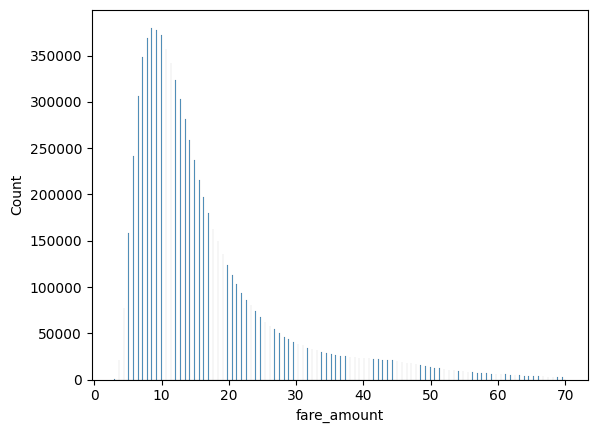

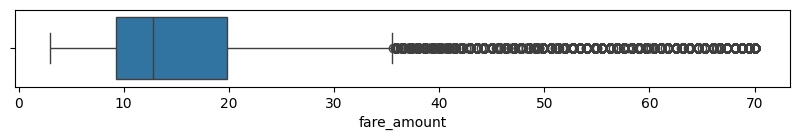

In [7]:
feat = target
summary = df[feat].describe()
print(summary)
iqr = summary.loc["75%"] - summary.loc["25%"]
upper_limit = summary.loc["75%"] + 1.5*iqr
lower_limit = summary.loc["25%"] - 1.5*iqr
print("Lower Outlier Limit :", lower_limit)
print("Upper Outlier Limit :", upper_limit)

sns.histplot(data=df, x=feat)
plt.show()
fig = plt.subplots(figsize=(10,1))
sns.boxplot(data=df, x=feat)
plt.show()

## Exploring Numeric Features

### Trip Distance

count    7.785073e+06
mean     2.731972e+00
std      2.799552e+00
min      1.000000e-02
25%      1.070000e+00
50%      1.740000e+00
75%      3.070000e+00
max      2.770000e+01
Name: trip_distance, dtype: float64 

Lower Outlier Limit : -1.9299999999999995
Upper Outlier Limit : 6.069999999999999


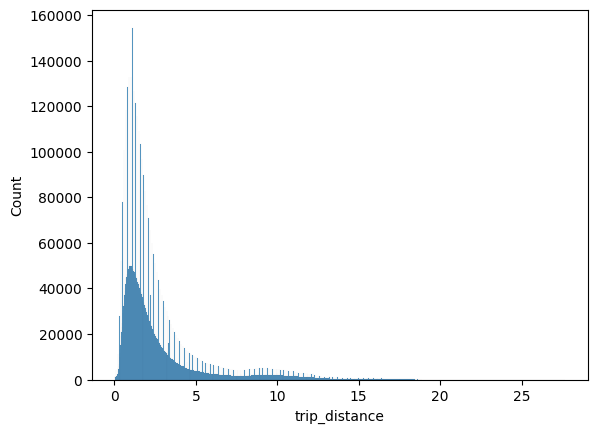

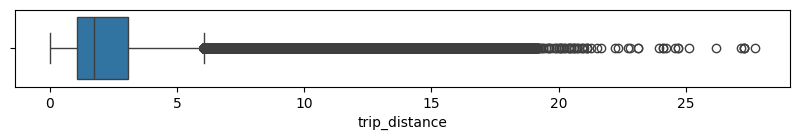

In [8]:
feat = "trip_distance"
summary = df[feat].describe()
print(summary, "\n")
iqr = summary.loc["75%"] - summary.loc["25%"]
upper_limit = summary.loc["75%"] + 1.5*iqr
lower_limit = summary.loc["25%"] - 1.5*iqr
print("Lower Outlier Limit :", lower_limit)
print("Upper Outlier Limit :", upper_limit)

sns.histplot(data=df, x=feat)
plt.show()
fig = plt.subplots(figsize=(10,1))
sns.boxplot(data=df, x=feat)
plt.show()

## Trip Duration (Minutes)

count    7.785073e+06
mean     1.423888e+01
std      9.427467e+00
min      1.016667e+00
25%      7.433333e+00
50%      1.191667e+01
75%      1.858333e+01
max      8.993333e+01
Name: trip_duration_min, dtype: float64 

Lower Outlier Limit : -9.291666666666664
Upper Outlier Limit : 35.30833333333333


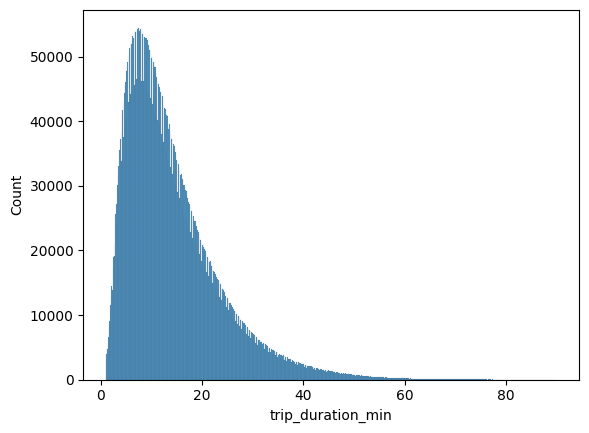

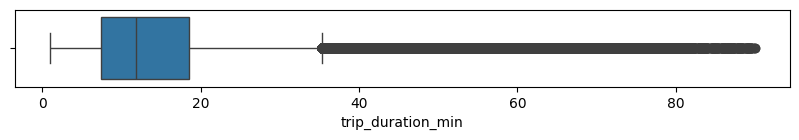

In [9]:
feat = "trip_duration_min"
summary = df[feat].describe()
print(summary, "\n")
iqr = summary.loc["75%"] - summary.loc["25%"]
upper_limit = summary.loc["75%"] + 1.5*iqr
lower_limit = summary.loc["25%"] - 1.5*iqr
print("Lower Outlier Limit :", lower_limit)
print("Upper Outlier Limit :", upper_limit)

sns.histplot(data=df, x=feat)
plt.show()
fig = plt.subplots(figsize=(10,1))
sns.boxplot(data=df, x=feat)
plt.show()

### Travel Rate

count    7.785073e+06
mean     1.095851e+01
std      5.781328e+00
min      1.346801e-02
25%      7.337580e+00
50%      9.712707e+00
75%      1.296418e+01
max      1.205714e+03
Name: travel_rate, dtype: float64 

Lower Outlier Limit : -1.1023239467015298
Upper Outlier Limit : 21.4040855587276


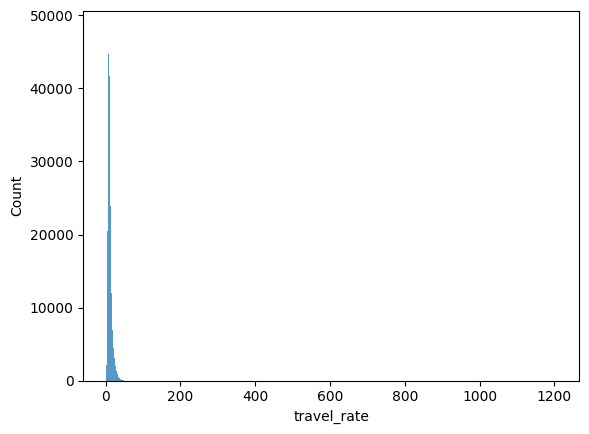

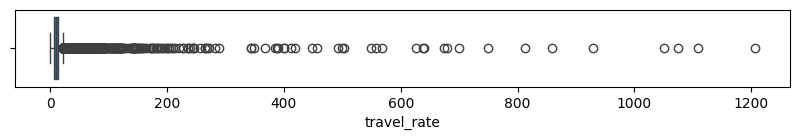

In [10]:
feat = "travel_rate"
summary = df[feat].describe()
print(summary, "\n")
iqr = summary.loc["75%"] - summary.loc["25%"]
upper_limit = summary.loc["75%"] + 1.5*iqr
lower_limit = summary.loc["25%"] - 1.5*iqr
print("Lower Outlier Limit :", lower_limit)
print("Upper Outlier Limit :", upper_limit)

sns.histplot(data=df, x=feat)
plt.show()
fig = plt.subplots(figsize=(10,1))
sns.boxplot(data=df, x=feat)
plt.show()

## Numeric Feature - Target Relationships

### Correlations

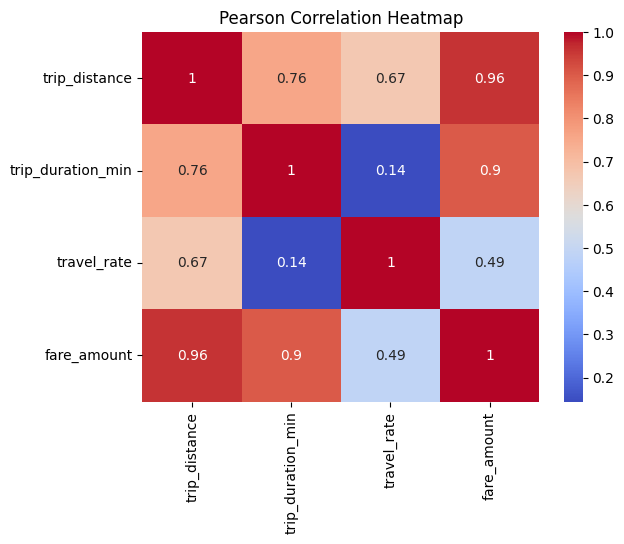

In [11]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Pearson Correlation Heatmap')
plt.show()

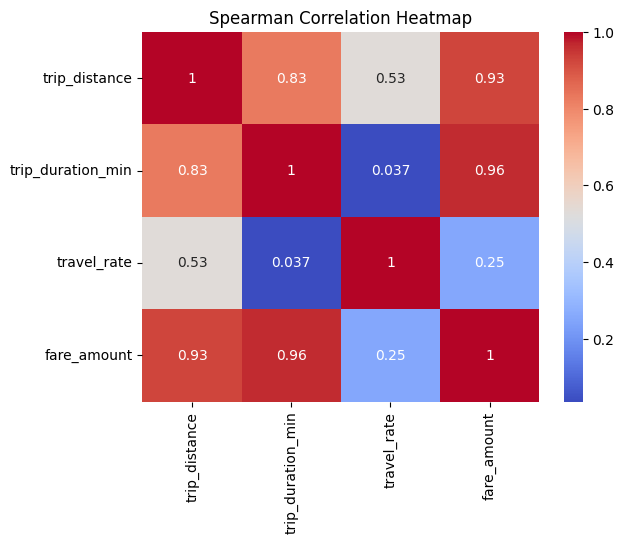

In [12]:
correlation_matrix = df.corr(method="spearman")
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Spearman Correlation Heatmap')
plt.show()

### Trip Distance

<Axes: xlabel='trip_distance', ylabel='fare_amount'>

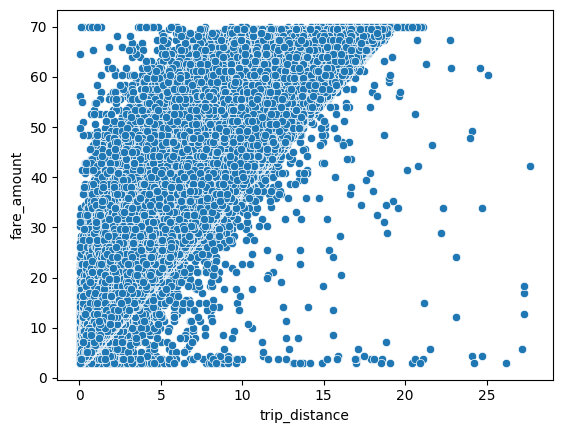

In [13]:
sns.scatterplot(data=df, x="trip_distance", y=target)

### Trip Duration

<Axes: xlabel='trip_duration_min', ylabel='fare_amount'>

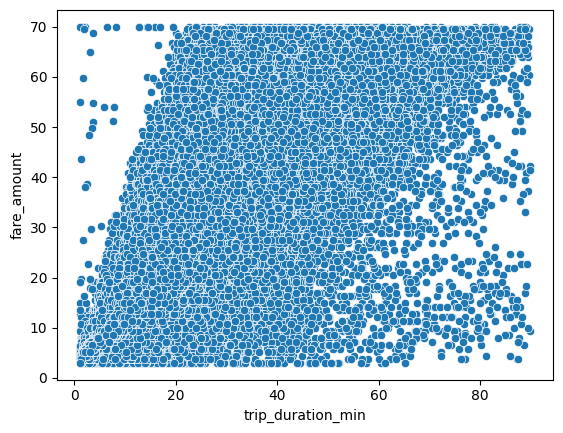

In [14]:
sns.scatterplot(data=df, x="trip_duration_min", y=target)

## Trip Distance and Duration vs Binned Fare Amount

Let's bin the fare amounts into buckets $10 wide and then analyze the data.
The $10 width was chosen because it results in 7 different bins and colors, making visualizations easier to analyze.
It might be better to bin in buckets of $5 or $2.5 later.

In [51]:
price_bins = [x for x in range(0,80,10)]
bins = price_bins[1:]

In [52]:
bins

[10, 20, 30, 40, 50, 60, 70]

In [53]:
df["price_bin"] = pd.cut(df["fare_amount"], bins=price_bins, labels=bins)

In [54]:
df["price_bin"].value_counts()

price_bin
20    3268707
10    2653750
30     975406
40     411569
50     292038
60     125381
70      58222
Name: count, dtype: int64

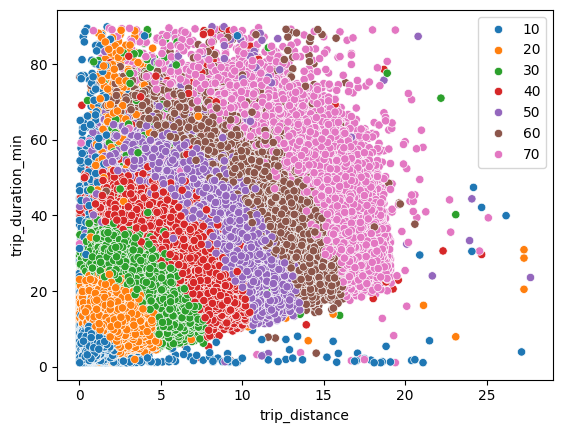

In [55]:
sns.scatterplot(data=df, x="trip_distance", y="trip_duration_min", hue="price_bin")
plt.legend(loc='upper right')
plt.show()

There are a few noteworthy observations:
1. There appears to be a radial relationship with trip distance, trip duration to the fare amount.
2. Some data points appear to be wildly out of place, and thus should be removed. For instance, there appears to be trips that take an hour or more but fall within the $10 price bin -- clearly impossible based on the fare calculation model specified by NYC.


Let's worry about bad data later and keep exploring the data as is.

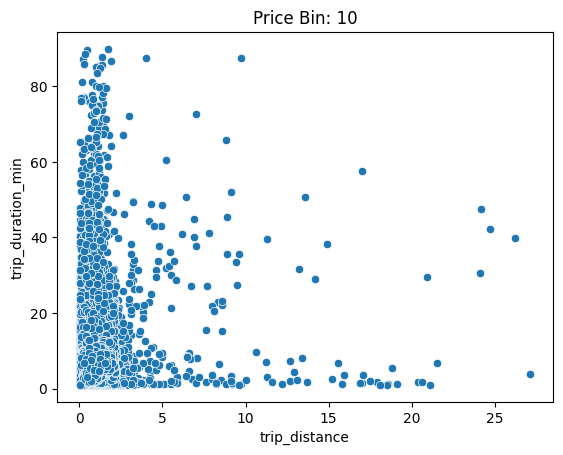

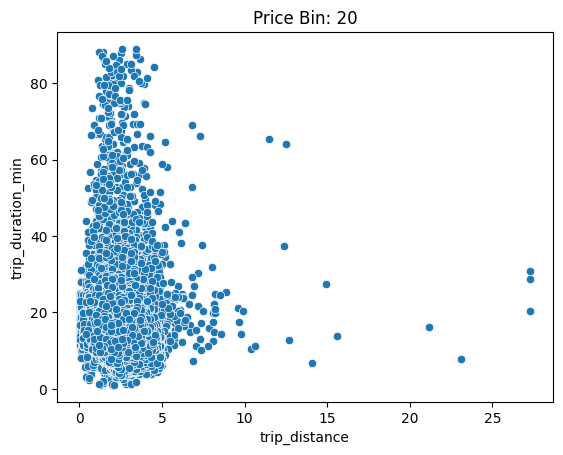

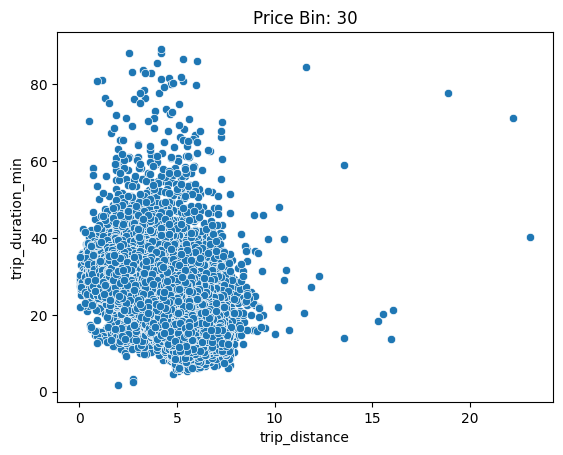

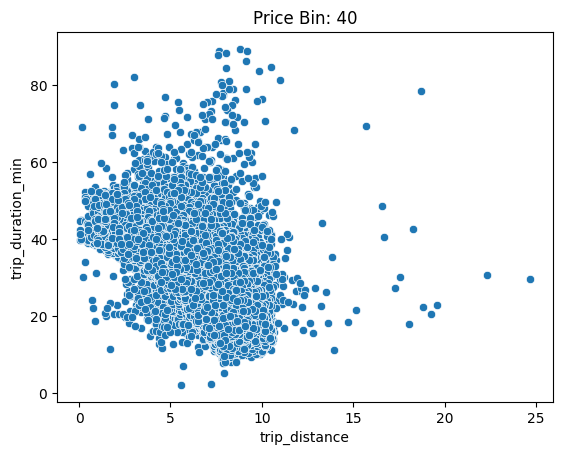

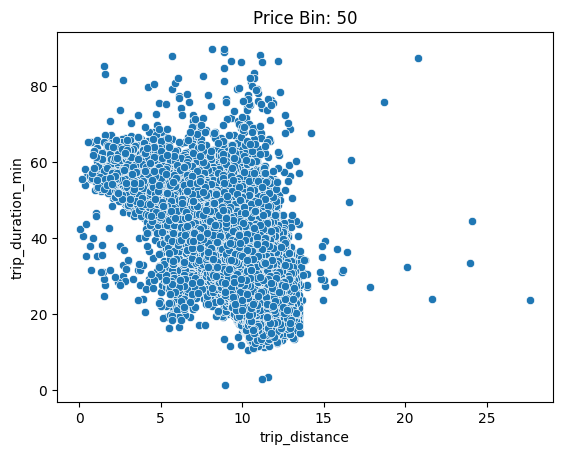

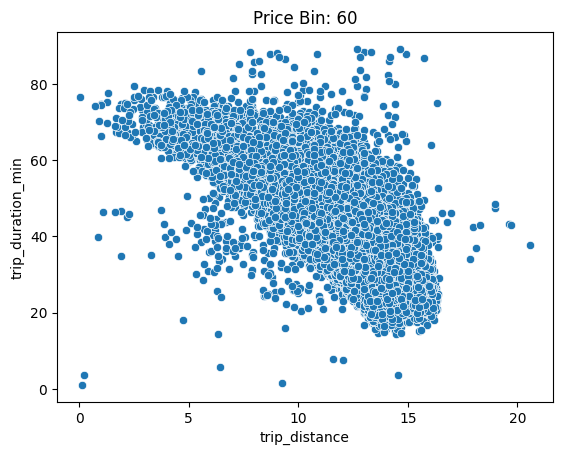

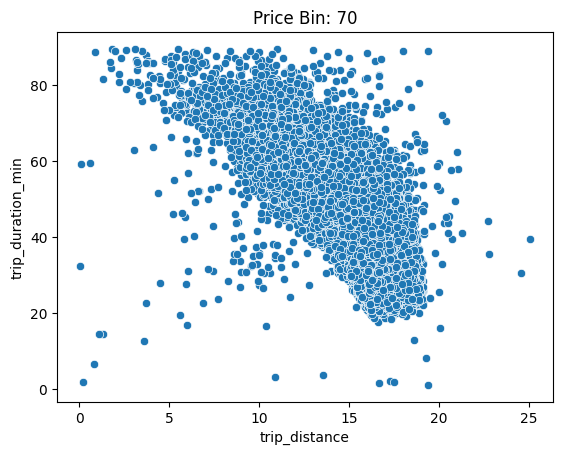

In [56]:
for bin in bins:
    sns.scatterplot(data=df.loc[df["price_bin"] == bin], x="trip_distance", y="trip_duration_min")
    plt.title(f"Price Bin: {bin}")
    plt.show()

### Polar Coordinates

Since a radial relationship seems apparent for some price bins in the preceeding plot, let's convert the data into polar coordinates.
Let's state that the X-axis is the trip distance and the Y-axis is the trip duration.
When converting to polar coordinates, we will use the angle relative to the X-axis (trip distance).
For example, $\theta$ = 0 when trip duration is 0.
Note that whatever axis we select to measure the angle from is arbitrary.
Also, let's convert $\theta$ from radians to degress to make the data easier to interpret.

The radius, <em>r</em>, is defined as :  <em>r</em> = $\sqrt{distance ^2 + duration^2}$

And $\theta$ = $\arcsin(duration / r)$  * (360&deg; / 2 $\pi$ radians)

or $\theta$ = $\arccos(distance / r)$ * (360&deg; / 2 $\pi$ radians)

In [57]:
df['r'] = np.sqrt(df["trip_distance"]**2 + df["trip_duration_min"]**2)
df["theta"] = np.arccos(df["trip_distance"]/ df["r"]) * (360/(2*np.pi))

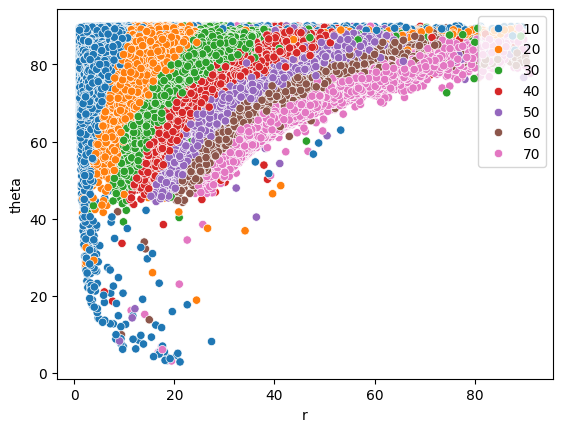

In [58]:
sns.scatterplot(data=df, x="r", y="theta", hue="price_bin")
plt.legend(loc='upper right')
plt.show()

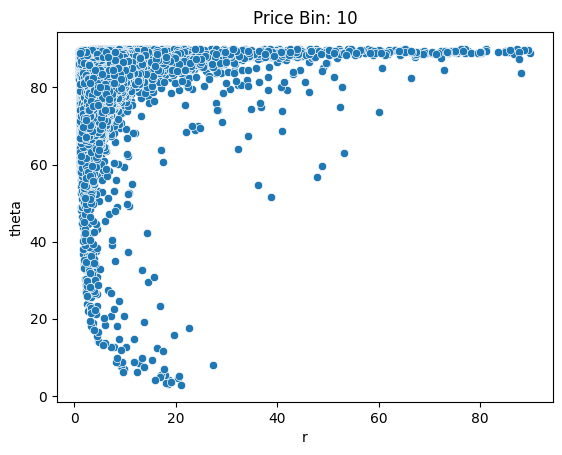

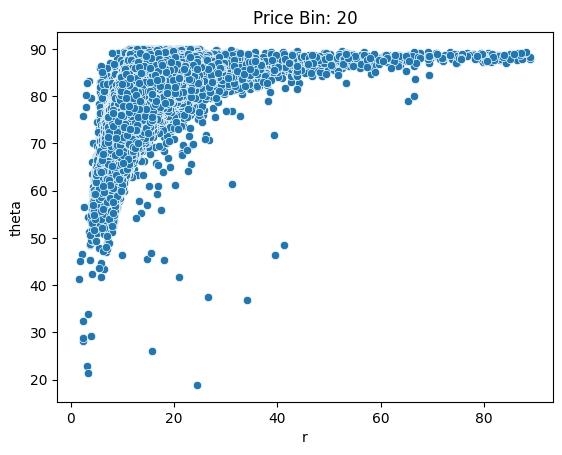

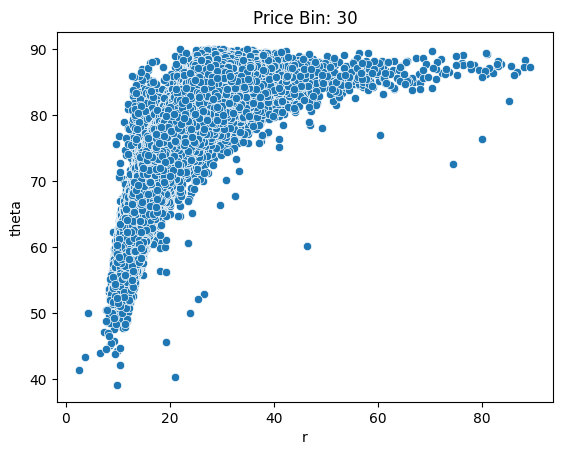

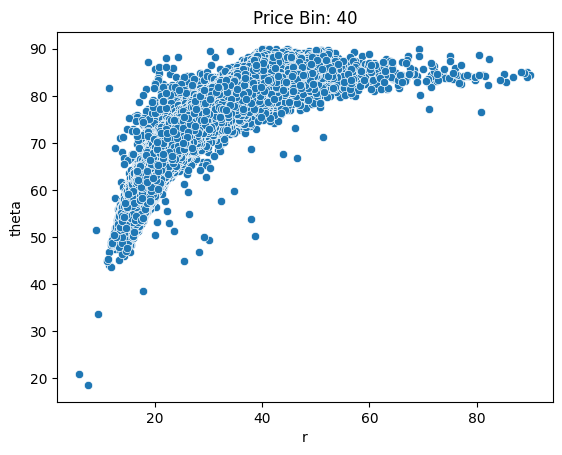

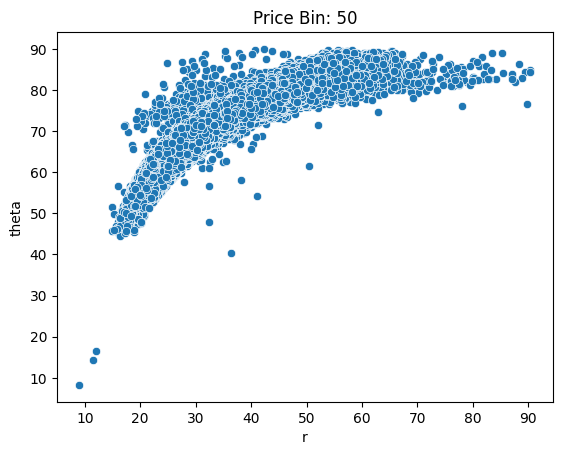

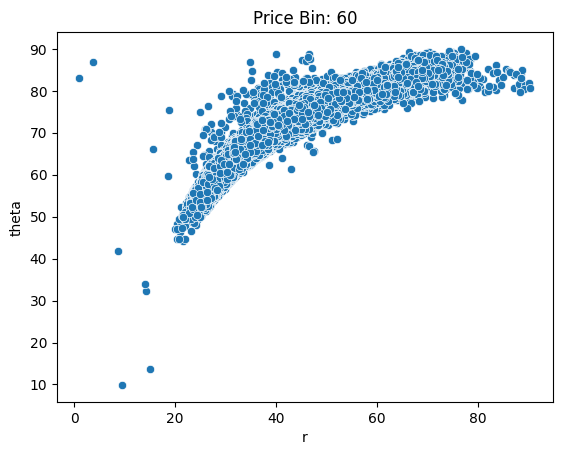

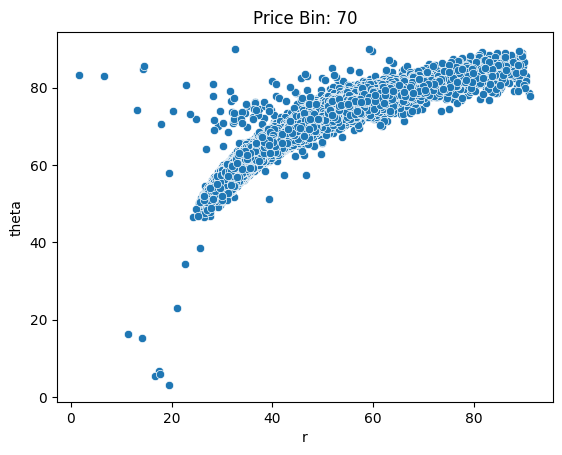

In [59]:
for bin in bins:
    sns.scatterplot(data=df.loc[df["price_bin"] == bin], x="r", y="theta")
    plt.title(f"Price Bin: {bin}")
    plt.show()

So, there was not a purely radial relationship with data points, but the polar representation of the data does provide some insight to each price bin.
Clearly, the $10 and $20 price bins have values all over the place and this must be addressed when cleaning the data.
In othe price bins there are outliers that are easy to spot visually, reinforcing that polar coordinates might be worth sticking with when analyzing the data to clean it.


Note: There were several other transformations tried that led nowhere, including exponential and polynomial transformations. These attempts at exploring the data have been omitted because they didn't provide anything valuable to the analysis.

Now to determine if a $5 or $2.5 bucket size should be used to bin the fare amount.

In [65]:
price_bins_5 = [x for x in range(0,75,5)]
bins_5 = price_bins_5[1:]

In [66]:
bins_5

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]

In [67]:
df["price_bin_5"] = pd.cut(df["fare_amount"], bins=price_bins_5, labels=bins_5)

In [68]:
df["price_bin_5"].value_counts().sort_index()

price_bin_5
5       99266
10    2554484
15    2104235
20    1164472
25     618758
30     356648
35     233796
40     177773
45     176173
50     115865
55      75429
60      49952
65      35214
70      23008
Name: count, dtype: int64

The $5 bucket width seems like a good split based on the value counts. To further split into buckets of $2.5 maybe isn't the best idea. It would also make visualizations extremely challenging to interpret.

## Initial EDA Findings

Initial EDA shows that there is a clear relationship between trip duration, trip distance to the fare amount.
This is unsurprising given the domain knowledge specifies this relationship.
Additionally, converting trip distance and trip duration into polar coordinates is a great way to visualize the data and identify outliers.
The next task is to start cleaning and filtering the data.
This will involve using domain rules, some statistics, and potentially some outlier detection algorithms.

There are some questions regarding the nature of higher speed taxi rides.
Currently, there is not enough information to understand the nature of higher speeds.
There might be other information that can help the model perform better, such as pickup time of day, if the trip is to the airport, etc.
Right now it is best to focus on what the domain knowledge states is relevant as this can form a baseline for model performance.
The same data cleaning methods can be employed on data with extra fields for additional context, so it will be easy to examine more fields in the data.